# ЛР8. Бинарная классификация изображений с логистической регрессией

Цель работы: изучить метод поиска по сетке в логистической регресии, чтобы реализовать бинарную классификацию изображений на "чистые"/"грязные" комнаты.

**Цель лабораторной работы:**

Изучить метод поиска по сетке в логистической регресии, чтобы реализовать бинарную классификацию изображений на "чистые"/"грязные" комнаты с использованием библиотеки scikit-learn. Сформировать исследование по формированию модели логистической регрессии для классификации изображению с наличием/отсутствием трещин в стене.

**Автор работы:**

|Выполнил(а)| Группа | Дата |
|---|---|---|
| ФИО | Группа | Дата |

## Предварительная подготовка данных

Загрузим необходимые нам модули.

In [3]:
import tempfile, os, zipfile, io
import requests
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2 
import os 
from random import shuffle 
from tqdm import tqdm 
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


Скачиваем архив с изображениями для тренировки модели, он доступен по [ссылке](https://github.com/SerjiEvg/data-analysis/raw/main/data/image_class.zip). И распаковываем его в директорию `image_class`

In [4]:
r = requests.get("https://github.com/SerjiEvg/data-analysis/raw/main/data/image_class.zip")
with r, zipfile.ZipFile(io.BytesIO(r.content)) as archive:
    archive.extractall('image_class')

Пути к внутренним каталогам изображений для тренировки, разделенных на два класса изображений: messy - "грязные" комнаты и "clean" - чистые комнаты. 

In [5]:
train_messy = "image_class/images/images/train/messy"
train_clean= "image_class/images/images/train/clean"
test_messy= "image_class/images/images/val/messy"
test_clean= "image_class/images/images/val/clean"
image_size = 128

Пример изображения "грязной" комнаты.

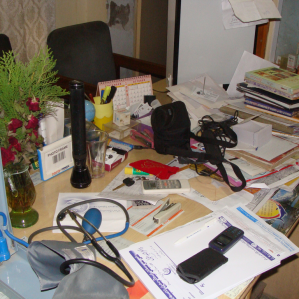

In [7]:
Image.open("image_class/images/images/train/messy/73.png")

Пример изображения "чистой" комнаты.

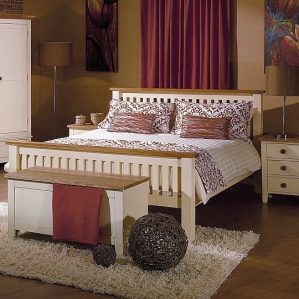

In [8]:
Image.open("image_class/images/images/train/clean/73.png")

Посмотрим как эти изображения выглядят в градациях серого. Сделаем это с помощью библиотеки OpenCV.

100%|██████████| 96/96 [00:01<00:00, 84.51it/s]


Text(0.5, 1.0, 'Вид грязной и чистой комнат в градациях серого')

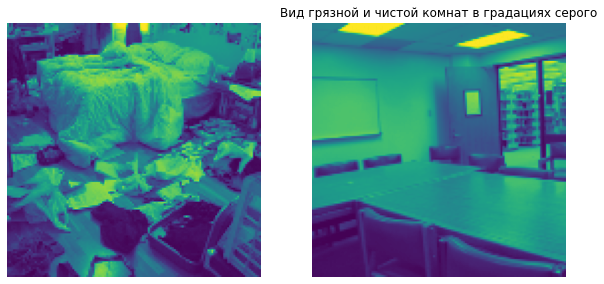

In [10]:
for image in tqdm(os.listdir(train_messy)): 
    path = os.path.join(train_messy, image)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
    img = cv2.resize(img, (image_size, image_size)).flatten()   
    np_img=np.asarray(img)
    
for image2 in tqdm(os.listdir(train_clean)): 
    path = os.path.join(train_clean, image2)
    img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
    img2 = cv2.resize(img2, (image_size, image_size)).flatten() 
    np_img2=np.asarray(img2)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(np_img.reshape(image_size, image_size))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(np_img2.reshape(image_size, image_size))
plt.axis('off')
plt.title("Вид грязной и чистой комнат в градациях серого")

Сделаем предварительную обработку всех изображений набора для обучения в градации серого и совместим размеры изображений.

In [11]:
def train_data():
    train_data_messy = [] 
    train_data_clean=[]
    for image1 in tqdm(os.listdir(train_messy)): 
        path = os.path.join(train_messy, image)
        img1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img1 = cv2.resize(img1, (image_size, image_size))
        train_data_messy.append(img1) 
    for image2 in tqdm(os.listdir(train_clean)): 
        path = os.path.join(train_clean, image)
        img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img2 = cv2.resize(img2, (image_size, image_size))
        train_data_clean.append(img2) 
    
    train_data= np.concatenate((np.asarray(train_data_messy), np.asarray(train_data_clean)), axis=0)
    return train_data 

То же самое проделаем для тестового набора изображений.

In [12]:
def test_data():
    test_data_messy = [] 
    test_data_clean=[]
    for image1 in tqdm(os.listdir(test_messy)): 
        path = os.path.join(test_messy, image1)
        img1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img1 = cv2.resize(img1, (image_size, image_size))
        test_data_messy.append(img1) 
    for image2 in tqdm(os.listdir(test_clean)): 
        path = os.path.join(test_clean, image2)
        img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img2 = cv2.resize(img2, (image_size, image_size))
        test_data_clean.append(img2) 
    
    test_data= np.concatenate((np.asarray(test_data_messy), np.asarray(test_data_clean)), axis=0) 
    return test_data 

In [13]:
train_data = train_data() 
test_data = test_data()

100%|██████████| 10/10 [00:00<00:00, 83.33it/s]


Сделаем конкатенацию наборов (но уже числовых массивов данных) и сделаем масштабирование.

In [14]:
x_data=np.concatenate((train_data, test_data), axis=0)
x_data = (x_data-np.min(x_data))/(np.max(x_data)-np.min(x_data))



Подготовим предварительные массивы данных для предсказаний.

In [15]:
z1 = np.zeros(96)
o1 = np.ones(96)
Y_train = np.concatenate((o1, z1), axis=0)
z = np.zeros(10)
o = np.ones(10)
Y_test = np.concatenate((o, z), axis=0)

Выполним конкатенацию массивов для предсказаний.

In [16]:
y_data=np.concatenate((Y_train, Y_test),axis=0).reshape(x_data.shape[0],1)

Количество массивов с изображениями (для тренировки и тестов) размером 128х128 у нас 212, а предсказание будет являться единственным значением, поэтому здесь будет вектор на 212 элементов.

In [17]:
print("X shape: " , x_data.shape)
print("Y shape: " , y_data.shape)

X shape:  (212, 128, 128)
Y shape:  (212, 1)


Производим деление на обучающий и тестовый набор в пропорции 85% : 15%

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=42)
number_of_train = x_train.shape[0]
number_of_test = x_test.shape[0]

В наборах нам еще понадобятся номера классов изображений, поэтому формируем некоторое расширение исходных массивов.

In [19]:
x_train_flatten = x_train.reshape(number_of_train, x_train.shape[1]*x_train.shape[2])
x_test_flatten = x_test.reshape(number_of_test, x_test.shape[1]*x_test.shape[2])
print("X train flatten", x_train_flatten.shape)
print("X test flatten", x_test_flatten.shape)

X train flatten (180, 16384)
X test flatten (32, 16384)


Транспонируем массивы значений

In [20]:
x_train = x_train_flatten.T
x_test = x_test_flatten.T
y_test = y_test.T
y_train = y_train.T
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (16384, 180)
x test:  (16384, 32)
y train:  (1, 180)
y test:  (1, 32)


## Формирование модели логистической регрессии

In [24]:
def initialize_weights_and_bias(dimension):
    w = np.full((dimension,1),0.01)
    b = 0.0
    return w, b

def sigmoid(z):
    y_head = 1/(1+np.exp(-z))
    return y_head

def forward_backward_propagation(w,b,x_train,y_train):
    # forward propagation
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z)
    loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)
    cost = (np.sum(loss))/x_train.shape[1]
    # backward propagation
    derivative_weight = (np.dot(x_train, ((y_head-y_train).T)))/x_train.shape[1]
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]
    gradients = {"derivative_weight": derivative_weight, "derivative_bias": derivative_bias}
    return cost,gradients

def update(w, b, x_train, y_train, learning_rate,number_of_iterarion):
    cost_list = []
    cost_list2 = []
    index = []
    
    for i in range(number_of_iterarion):
        
        cost,gradients = forward_backward_propagation(w,b,x_train,y_train)
        cost_list.append(cost)
        
        w = w - learning_rate * gradients["derivative_weight"]
        b = b - learning_rate * gradients["derivative_bias"]
        if i % 100 == 0:
            cost_list2.append(cost)
            index.append(i)
            print ("Стоимость после итерации %i: %f" %(i, cost))
    
    parameters = {"weight": w,"bias": b}
    plt.plot(index,cost_list2)
    plt.xticks(index,rotation='vertical')
    plt.xlabel("Номер итерации")
    plt.ylabel("Стоимость")
    plt.show()
    return parameters, gradients, cost_list

def predict(w,b,x_test):
    
    z = sigmoid(np.dot(w.T,x_test)+b)
    Y_prediction = np.zeros((1,x_test.shape[1]))

    for i in range(z.shape[1]):
        if z[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction

def logistic_regression(x_train, y_train, x_test, y_test, learning_rate ,  num_iterations):

    dimension =  x_train.shape[0]
    w,b = initialize_weights_and_bias(dimension)

    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate,num_iterations)
    
    y_prediction_test = predict(parameters["weight"],parameters["bias"],x_test)
    y_prediction_train = predict(parameters["weight"],parameters["bias"],x_train)
    
    print("Test Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100,2)))
    print("Train Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100,2)))

Стоимость после итерации 0: nan
Стоимость после итерации 100: 0.032316
Стоимость после итерации 200: 0.014960
Стоимость после итерации 300: 0.009692
Стоимость после итерации 400: 0.007167
Стоимость после итерации 500: 0.005685
Стоимость после итерации 600: 0.004711
Стоимость после итерации 700: 0.004022
Стоимость после итерации 800: 0.003510
Стоимость после итерации 900: 0.003114
Стоимость после итерации 1000: 0.002799
Стоимость после итерации 1100: 0.002543
Стоимость после итерации 1200: 0.002330
Стоимость после итерации 1300: 0.002151
Стоимость после итерации 1400: 0.001997


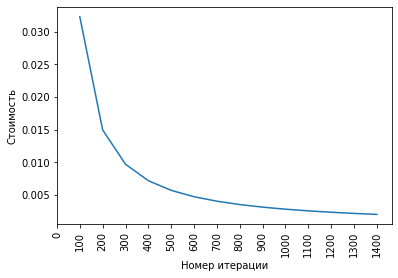

Test Accuracy: 90.62 %
Train Accuracy: 100.0 %


In [25]:
logistic_regression(x_train, y_train, x_test, y_test, learning_rate = 0.01, num_iterations = 1500)

Подгонка модели по сетке

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]},
logistic_regression=LogisticRegression(random_state=42)
log_reg_cv=GridSearchCV(logistic_regression, grid, cv=10)
log_reg_cv.fit(x_train.T, y_train.T)


GridSearchCV(cv=10, estimator=LogisticRegression(random_state=42),
             param_grid=({'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'penalty': ['l1', 'l2']},))

In [30]:
print("Лучшие гиперпараметры: ", log_reg_cv.best_params_)
print("Точность: ", log_reg_cv.best_score_)

Лучшие гиперпараметры:  {'C': 0.001, 'penalty': 'l2'}
Точность:  0.961111111111111


In [32]:
log_reg= LogisticRegression(C=1,penalty="l2")
log_reg.fit(x_train.T,y_train.T)
print("Точность на тестовом наборе: {} ".format(log_reg.fit(x_test.T, y_test.T).score(x_test.T, y_test.T)))
print("Точность на обучающем наборе: {} ".format(log_reg.fit(x_train.T, y_train.T).score(x_train.T, y_train.T)))

Точность на тестовом наборе: 1.0 
Точность на обучающем наборе: 1.0 


## Задание

Имеется набор данных состоит из 3-х архивов: 

- [crack_wall_train_cracked.zip](https://github.com/SerjiEvg/data-analysis/raw/main/data/crack_wall/crack_wall_train_cracked.zip) 

- [crack_wall_train_uncracked.zip](https://github.com/SerjiEvg/data-analysis/raw/main/data/crack_wall/crack_wall_train_uncracked.zip) 

- [crack_wall_test.zip](https://github.com/SerjiEvg/data-analysis/raw/main/data/crack_wall/crack_wall_test.zip) 

Архив «crack_wall_train_cracked.zip» содержит в общей сложности 7501 изображение, содержащее трещины, а архив «crack_wall_train_uncracked.zip» содержит 7467 изображений без трещин. 
Все изображения имеют формат «.jpg». Эти изображения не маркированы, т.е. метки не предусмотрены. 

Архив «crack_wall_test.zip» состоит из тестовых изображений набора данных. Всего в этой папке 2000 изображений (все файлы «.jpg»). Внутри архива имеется файл annotation.csv в котором имеются метки изображений и соотнесение их к определенному классу.

Цель этой задачи — предсказать класс каждого из этих тестовых изображений. Класс может быть либо «cracked», либо «uncracked». Слудет воспользоваться методикой обработки с использованием логистической регрессии, которая использовалась в примере.

Для набора тестовых изображений (из архива crack_wall_test.zip) выполните предсказание и сформируйте матрицу путанницы.